<a href="https://colab.research.google.com/github/Luispabon88/Hackaton2022/blob/main/CMS_Higgs_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMS Data and Higgs plot

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
#Estos comandos sirven para subir el archivo en Google Colab
from google.colab import files
uploaded = files.upload()

Saving SMHiggsToZZTo4L.csv to SMHiggsToZZTo4L.csv


In [73]:
#Se suben los datos en formato csv.
datos_desde_csv = pd.read_csv('SMHiggsToZZTo4L.csv', index_col = [0,1])

## Primera fase: Se filtran los eventos interesantes

In [104]:
#Se eligen los eventos que tiene 4 o más muones
df_4mu = datos_desde_csv.loc[datos_desde_csv['nMuon'] >= 4]

#Se busca que los datos tengan buen aislamiento
df_iso_4mu = df_4mu.loc[np.abs(df_4mu['Muon_pfRelIso04_all']) < 0.4].copy()

#Se busca que los datos esten cercanos al vértice principal y que tengan poca incertidumbre
df_iso_4mu['Muon_ip3d'] = np.sqrt(np.power(df_iso_4mu['Muon_dxy'],2) + np.power(df_iso_4mu['Muon_dz'],2))
df_iso_4mu['Muon_sip3d'] = np.divide( df_iso_4mu['Muon_ip3d'],np.sqrt(np.power(df_iso_4mu['Muon_dxyErr'],2) + np.power(df_iso_4mu['Muon_dzErr'],2)))
df_uncer_4mu = df_iso_4mu.loc[(df_iso_4mu['Muon_sip3d']<4) & (np.abs(df_iso_4mu['Muon_dxy'])< 0.5)&(np.abs(df_iso_4mu['Muon_dz'])<1.0)].copy()

#Nos aseguramos que solo quedan 4 muones en cada evento
df_uncer_4mu['rnMuon'] = df_uncer_4mu.groupby(level = 0).run.transform('sum')

#Se busca que hayan 4 muones, 2 con carga positiva y 2 con carga negativa
df_uncer_4mu['Muon_Charge_Sum'] = df_uncer_4mu.groupby(level = 0).Muon_charge.transform('sum')
df_filt_4mu = df_uncer_4mu.loc[(df_uncer_4mu['rnMuon']==4) & (df_uncer_4mu['Muon_Charge_Sum'] == 0.0)]

## Segunda Fase: Se aparean los muones que son capaces de dar un boson Z


In [94]:
#Definimos la función que calcula la masa a partir de 2 cuadrimomentums
def calc_mass(pt1,eta1,phi1,mass1,pt2,eta2,phi2,mass2):
  px1 = pt1*np.cos(phi1)
  py1 = pt1*np.sin(phi1)
  pz1 = pt1*np.sinh(eta1)
  px2 = pt2*np.cos(phi2)
  py2 = pt2*np.sin(phi2)
  pz2 = pt2*np.sinh(eta2)
  return np.sqrt(np.power((mass1 + mass2),2) + (np.power((px1 +px2),2) + np.power((py1 + py2),2) + np.power((pz1 + pz2),2)))

#Realizamos una función que elije en cada evento el mejor par de muones que logran crear un Boson Z
def best_Z(df):
  mu_pt = df['Muon_pt'].reset_index(drop = True).to_numpy()
  mu_eta = df['Muon_eta'].reset_index(drop = True).to_numpy()
  mu_phi = df['Muon_phi'].reset_index(drop = True).to_numpy()
  mu_mass = df['Muon_mass'].reset_index(drop = True).to_numpy()
  mu_charge = df['Muon_charge'].reset_index(drop = True).to_numpy()
  zmass = 91.2
  bestmass = -1
  idx=[0,0]
  for i in range(0,mu_charge.size):
    for j in range(i+1,mu_charge.size):
      if(mu_charge[i] != mu_charge[j]):
        thismass = calc_mass(mu_pt[i],mu_eta[i],mu_phi[i],mu_mass[i],mu_pt[j],mu_eta[j],mu_phi[j],mu_mass[j])
        #print(thismass)
        if(np.abs(zmass - thismass) < np.abs(zmass - bestmass)):
          bestmass = thismass
          idx[0] = i
          idx[1] = j
  idy = np.ones(mu_charge.size)
  idy[idx[0]] = 0
  idy[idx[1]] = 0
  npidy = np.array(idy)
  df = df.reset_index()
  extra = pd.DataFrame(npidy,columns = ['Idx'])
  final = pd.concat([df,extra], axis=1)
  final.set_index(['entry','subentry'], drop = True, inplace = True)
  return final

In [95]:
#Señalamos en una nueva columna cuáles son los mejores muones que logran crear un bosón Z
df_bestZ_4mu = df_filt_4mu.groupby(level = 0).apply(best_Z)

## Tercera Fase: eliminamos los muones que estan muy cercanos

In [96]:
#Creamos una función que calcule la diferencia en pseudorapidez y el ángulo entre 2 vectores
def distance(df):
  mu_eta = df['Muon_eta'].reset_index(drop = True).to_numpy()
  mu_phi = df['Muon_phi'].reset_index(drop = True).to_numpy()
  idx = df['Idx'].reset_index(drop = True).to_numpy()
  dr = np.zeros(idx.size)
  for i in range(0,idx.size):
    for j in range(i+1, idx.size):
      if(idx[i] == idx[j]):
        delta_r = np.sqrt(np.power(mu_eta[i] + mu_eta[j],2) + np.power(mu_phi[i] + mu_phi[j],2))
        dr[i] = delta_r
        dr[j] = delta_r
  df = df.reset_index()
  extra = pd.DataFrame(dr,columns = ['Delta_R'])
  final = pd.concat([df,extra], axis=1)
  final.set_index(['entry','subentry'], drop = True, inplace = True)
  return final

In [97]:
#Se eliminan los muones que son cercanos en pseudorapidez y ángulo
df_deltaR_4mu = df_bestZ_4mu.groupby(level = 0).apply(distance)
df_cut_deltaR_4mu = df_deltaR_4mu.loc[df_deltaR_4mu['Delta_R'] > 0.02].copy()

#Nos aseguramos que solo quedan 4 muones en cada evento
df_cut_deltaR_4mu['rrnMuon'] = df_cut_deltaR_4mu.groupby(level = 0).run.transform('sum')
df_f_deltaR_4mu = df_cut_deltaR_4mu.loc[(df_cut_deltaR_4mu['rrnMuon']==4)].copy()

## Cuarta Fase: Calculamos la masa de los bosones Z a partir de los muones

In [98]:
#Creamos una función para crear la masa de los bosones Z
def create_Z(df):
  mu_pt = df['Muon_pt'].reset_index(drop = True).to_numpy()
  mu_eta = df['Muon_eta'].reset_index(drop = True).to_numpy()
  mu_phi = df['Muon_phi'].reset_index(drop = True).to_numpy()
  mu_mass = df['Muon_mass'].reset_index(drop = True).to_numpy()
  idx = df['Idx'].reset_index(drop = True).to_numpy()
  dz = np.zeros(idx.size)
  for i in range(0,idx.size):
    for j in range(i+1, idx.size):
      if(idx[i] == idx[j]):
        z_mass = calc_mass(mu_pt[i],mu_eta[i],mu_phi[i],mu_mass[i],mu_pt[j],mu_eta[j],mu_phi[j],mu_mass[j])
        dz[i] = z_mass
        dz[j] = z_mass
  df = df.reset_index()
  extra = pd.DataFrame(dz,columns = ['Z_mass'])
  final = pd.concat([df,extra], axis=1)
  final.set_index(['entry','subentry'], drop = True, inplace = True)
  return final

In [99]:
#Aplicamos la función
df_withZ_4mu = df_f_deltaR_4mu.groupby(level = 0).apply(create_Z)

## Quinta Fase: Seleccionamos los eventos con candidatos de Z que pudieran formar el Boson de Higgs

In [100]:
#Eliminamos los eventos que no tienen bosones de Higgs en el rango (12,120)
df_cutZ_4mu = df_withZ_4mu.loc[(df_withZ_4mu['Z_mass'] > 12) & (df_withZ_4mu['Z_mass'] < 120)].copy()

#Nos aseguramos que solo quedan 4 muones en cada evento
df_cutZ_4mu['rrrnMuon'] = df_cutZ_4mu.groupby(level = 0).run.transform('sum')
df_cutZ_4mu = df_cutZ_4mu.loc[(df_cutZ_4mu['rrrnMuon']==4)]

## Sexta Fase: Recreamos la masa del Boson de Higgs a partir de los 4muones

In [101]:
#Realizamos una función que cálcule la masa del Boson de Higgs a partir de 4 leptones
def calc_massH(pt1,eta1,phi1,mass1,pt2,eta2,phi2,mass2,pt3,eta3,phi3,mass3,pt4,eta4,phi4,mass4):
  px1 = pt1*np.cos(phi1)
  py1 = pt1*np.sin(phi1)
  pz1 = pt1*np.sinh(eta1)
  px2 = pt2*np.cos(phi2)
  py2 = pt2*np.sin(phi2)
  pz2 = pt2*np.sinh(eta2)
  px3 = pt2*np.cos(phi2)
  py3 = pt2*np.sin(phi2)
  pz3 = pt2*np.sinh(eta2)
  px4 = pt2*np.cos(phi2)
  py4 = pt2*np.sin(phi2)
  pz4 = pt2*np.sinh(eta2)
  return np.sqrt(np.power((mass1 + mass2 + mass3 + mass4),2) + (np.power((px1 +px2 + px3 + px4),2) + np.power((py1 + py2 + py3 + py4),2) + np.power((pz1 + pz2 + pz3 + pz4),2)))

#Hacemos la función para recrear la masa del Boson de Higgs
def create_H(df):
  mu_pt = df['Muon_pt'].reset_index(drop = True).to_numpy()
  mu_eta = df['Muon_eta'].reset_index(drop = True).to_numpy()
  mu_phi = df['Muon_phi'].reset_index(drop = True).to_numpy()
  mu_mass = df['Muon_mass'].reset_index(drop = True).to_numpy()
  idx = df['Idx'].reset_index(drop = True).to_numpy()
  dH = np.ones(idx.size)
  H_mass = calc_massH(mu_pt[0],mu_eta[0],mu_phi[0],mu_mass[0],mu_pt[1],mu_eta[1],mu_phi[1],mu_mass[1],mu_pt[2],mu_eta[2],mu_phi[2],mu_mass[2],mu_pt[3],mu_eta[3],mu_phi[3],mu_mass[3])
  dH = dH * H_mass
  df = df.reset_index()
  extra = pd.DataFrame(dH,columns = ['H_mass'])
  final = pd.concat([df,extra], axis=1)
  final.set_index(['entry','subentry'], drop = True, inplace = True)
  return final

In [102]:
#Colocamos los datos calculados en el DataFrame
df_withH_4mu = df_cutZ_4mu.groupby(level = 0).apply(create_H)

## Plot

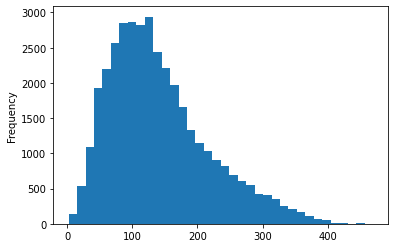

In [103]:
#Realizamos el Histograma
df_withH_4mu['H_mass'].plot.hist(bins = 36)